In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Using cached https://download.pytorch.org/whl/cu113/torch-1.12.1%2Bcu113-cp39-cp39-linux_x86_64.whl (1837.7 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchvision-0.13.1%2Bcu113-cp39-cp39-linux_x86_64.whl (23.4 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchaudio-0.12.1%2Bcu113-cp39-cp39-linux_x86_64.whl (3.8 MB)
     |████████████████████████████████| 62 kB 2.3 MB/s  eta 0:00:01
  Using cached Pillow-9.5.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.4 MB)
  Using cached numpy-1.25.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.7 MB)
     |████████████████████████████████| 199 kB 42.9 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 103.0 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 95.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 77 kB 7.5 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
from data import get_data
from model import NetLN
from utils_train import train, test, infer
from utils_plot import imshow, plot_misclassified
import torch
import numpy as np
import torchvision


In [8]:
'''
Loading data without normalization
'''

train_ds = get_data(train=True, normalize=False)
test_ds = get_data(train=False, normalize=False)

Compose(
    ToTensor()
)
Files already downloaded and verified
Compose(
    ToTensor()
)
Files already downloaded and verified


In [9]:
'''
Feeding the data to dataloader to get tensors
'''



SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_ds, **dataloader_args)

CUDA Available? True


In [10]:
'''
Getting statistics of the data to normalize accordingly
'''

dataiter = iter(train_loader)
images, labels = next(dataiter)
print('[Train]')
print(' - Numpy Shape:', train_ds.data.shape)
print(' - Tensor Shape:', images.size())
print(' - min:', np.min(train_ds.data))
print(' - max:', np.max(train_ds.data))
print(' - mean R:', torch.mean(images[:, 0, :, :]))
print(' - std R:', torch.std(images[:, 0, :, :]))
print(' - var R:', torch.var(images[:, 0, :, :]))

print(' - mean G:', torch.mean(images[:, 1, :, :]))
print(' - std G:', torch.std(images[:, 1, :, :]))
print(' - var G:', torch.var(images[:, 1, :, :]))

print(' - mean B:', torch.mean(images[:, 2, :, :]))
print(' - std B:', torch.std(images[:, 2, :, :]))
print(' - var B:', torch.var(images[:, 2, :, :]))

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([128, 3, 32, 32])
 - min: 0
 - max: 255
 - mean R: tensor(0.4870)
 - std R: tensor(0.2516)
 - var R: tensor(0.0633)
 - mean G: tensor(0.4835)
 - std G: tensor(0.2478)
 - var G: tensor(0.0614)
 - mean B: tensor(0.4535)
 - std B: tensor(0.2661)
 - var B: tensor(0.0708)


In [2]:
'''
Getting normalized data
'''

train_ds = get_data(train=True, normalize=True)
test_ds = get_data(train=False, normalize=True)
infer_ds = get_data(train=False, normalize=True)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.49, 0.45), std=(0.23, 0.23, 0.25))
)
Files already downloaded and verified
Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.49, 0.45), std=(0.23, 0.23, 0.25))
)
Files already downloaded and verified
Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.49, 0.45), std=(0.23, 0.23, 0.25))
)
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
infer_dataloader_args = dict(shuffle=False, batch_size=1, num_workers=4, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_ds, **dataloader_args)

# infer dataloader
infer_loader = torch.utils.data.DataLoader(infer_ds, **infer_dataloader_args)

CUDA Available? True


In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('[Train]')
print(' - Numpy Shape:', train_ds.data.shape)
print(' - Tensor Shape:', images.size())
print(' - min:', np.min(train_ds.data))
print(' - max:', np.max(train_ds.data))
print(' - mean R:', torch.mean(images[:, 0, :, :]))
print(' - std R:', torch.std(images[:, 0, :, :]))
print(' - var R:', torch.var(images[:, 0, :, :]))

print(' - mean G:', torch.mean(images[:, 1, :, :]))
print(' - std G:', torch.std(images[:, 1, :, :]))
print(' - var G:', torch.var(images[:, 1, :, :]))

print(' - mean B:', torch.mean(images[:, 2, :, :]))
print(' - std B:', torch.std(images[:, 2, :, :]))
print(' - var B:', torch.var(images[:, 2, :, :]))

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([128, 3, 32, 32])
 - min: 0
 - max: 255
 - mean R: tensor(-0.0567)
 - std R: tensor(1.0939)
 - var R: tensor(1.1967)
 - mean G: tensor(-0.0282)
 - std G: tensor(1.0774)
 - var G: tensor(1.1608)
 - mean B: tensor(0.0140)
 - std B: tensor(1.0643)
 - var B: tensor(1.1328)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


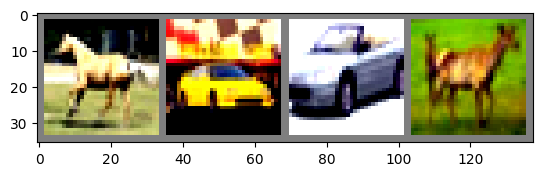

horse automobile automobile deer 


In [14]:
# get some random training images
batch_size=4
dataiter = iter(train_loader)
classes = train_ds.classes
images, labels = next(dataiter)
sampled_images = images[0: batch_size]
sampled_labels = labels[0: batch_size]

# show images
imshow(torchvision.utils.make_grid(sampled_images))
# print labels
print(' '.join(f'{classes[sampled_labels[j]]:5s}' for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


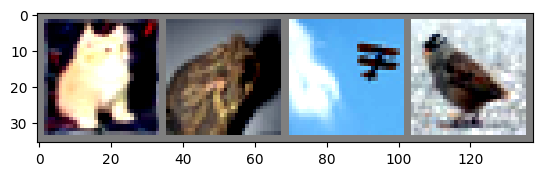

cat   frog  airplane bird 


In [15]:
# get some random testing images
batch_size=4
dataiter = iter(test_loader)
classes = test_ds.classes
images, labels = next(dataiter)
sampled_images = images[0: batch_size]
sampled_labels = labels[0: batch_size]

# show images
imshow(torchvision.utils.make_grid(sampled_images))
# print labels
print(' '.join(f'{classes[sampled_labels[j]]:5s}' for j in range(batch_size)))

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = NetLN().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
         GroupNorm-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             576
              ReLU-6            [-1, 8, 32, 32]               0
         GroupNorm-7            [-1, 8, 32, 32]              16
           Dropout-8            [-1, 8, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             128
        GroupNorm-10           [-1, 16, 32, 32]              32
        MaxPool2d-11           [-1, 16, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           2,304
             ReLU-13           [-1, 16, 16, 16]               0
        GroupNorm-14           [-1

In [8]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []


In [9]:
from torch.optim.lr_scheduler import StepLR
model =  NetLN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    # scheduler.step()
    test(model, device, test_loader, test_losses, test_acc)
    # scheduler.step(test_acc[-1])

EPOCH: 0


Loss=1.3336771726608276 Batch_id=390 Accuracy=38.35: 100%|██████████| 391/391 [00:11<00:00, 33.06it/s]



Test set: Average loss: 1.4480, Accuracy: 4776/10000 (47.76%)

EPOCH: 1


Loss=1.3270220756530762 Batch_id=390 Accuracy=52.65: 100%|██████████| 391/391 [00:11<00:00, 33.97it/s]



Test set: Average loss: 1.1897, Accuracy: 5687/10000 (56.87%)

EPOCH: 2


Loss=1.1842854022979736 Batch_id=390 Accuracy=59.75: 100%|██████████| 391/391 [00:11<00:00, 33.84it/s]



Test set: Average loss: 1.0661, Accuracy: 6143/10000 (61.43%)

EPOCH: 3


Loss=0.9656075239181519 Batch_id=390 Accuracy=63.54: 100%|██████████| 391/391 [00:11<00:00, 33.97it/s]



Test set: Average loss: 1.0319, Accuracy: 6276/10000 (62.76%)

EPOCH: 4


Loss=0.7987731099128723 Batch_id=390 Accuracy=66.54: 100%|██████████| 391/391 [00:11<00:00, 34.13it/s]



Test set: Average loss: 0.9582, Accuracy: 6626/10000 (66.26%)

EPOCH: 5


Loss=0.9298941493034363 Batch_id=390 Accuracy=68.77: 100%|██████████| 391/391 [00:11<00:00, 33.36it/s]



Test set: Average loss: 0.8662, Accuracy: 6893/10000 (68.93%)

EPOCH: 6


Loss=0.9769374132156372 Batch_id=390 Accuracy=70.76: 100%|██████████| 391/391 [00:11<00:00, 34.27it/s]



Test set: Average loss: 0.8256, Accuracy: 7034/10000 (70.34%)

EPOCH: 7


Loss=0.870637059211731 Batch_id=390 Accuracy=72.49: 100%|██████████| 391/391 [00:11<00:00, 33.17it/s] 



Test set: Average loss: 0.8256, Accuracy: 7061/10000 (70.61%)

EPOCH: 8


Loss=0.8012576103210449 Batch_id=390 Accuracy=73.79: 100%|██████████| 391/391 [00:11<00:00, 33.04it/s]



Test set: Average loss: 0.7956, Accuracy: 7210/10000 (72.10%)

EPOCH: 9


Loss=1.0533349514007568 Batch_id=390 Accuracy=74.54: 100%|██████████| 391/391 [00:11<00:00, 32.59it/s] 



Test set: Average loss: 0.7883, Accuracy: 7247/10000 (72.47%)

EPOCH: 10


Loss=0.7180527448654175 Batch_id=390 Accuracy=75.72: 100%|██████████| 391/391 [00:11<00:00, 34.07it/s] 



Test set: Average loss: 0.7603, Accuracy: 7362/10000 (73.62%)

EPOCH: 11


Loss=0.5983060002326965 Batch_id=390 Accuracy=76.47: 100%|██████████| 391/391 [00:10<00:00, 36.39it/s] 



Test set: Average loss: 0.7198, Accuracy: 7434/10000 (74.34%)

EPOCH: 12


Loss=0.8712477684020996 Batch_id=390 Accuracy=77.09: 100%|██████████| 391/391 [00:06<00:00, 57.34it/s] 



Test set: Average loss: 0.7299, Accuracy: 7466/10000 (74.66%)

EPOCH: 13


Loss=0.6492059230804443 Batch_id=390 Accuracy=77.80: 100%|██████████| 391/391 [00:06<00:00, 56.13it/s] 



Test set: Average loss: 0.7327, Accuracy: 7439/10000 (74.39%)

EPOCH: 14


Loss=0.6020802855491638 Batch_id=390 Accuracy=78.20: 100%|██████████| 391/391 [00:06<00:00, 64.72it/s] 



Test set: Average loss: 0.7458, Accuracy: 7446/10000 (74.46%)

EPOCH: 15


Loss=0.612617552280426 Batch_id=390 Accuracy=79.02: 100%|██████████| 391/391 [00:06<00:00, 63.72it/s]  



Test set: Average loss: 0.7185, Accuracy: 7534/10000 (75.34%)

EPOCH: 16


Loss=0.6922038793563843 Batch_id=390 Accuracy=79.27: 100%|██████████| 391/391 [00:06<00:00, 64.89it/s] 



Test set: Average loss: 0.7257, Accuracy: 7465/10000 (74.65%)

EPOCH: 17


Loss=0.7331057786941528 Batch_id=390 Accuracy=79.85: 100%|██████████| 391/391 [00:06<00:00, 64.09it/s] 



Test set: Average loss: 0.7229, Accuracy: 7478/10000 (74.78%)

EPOCH: 18


Loss=0.467136949300766 Batch_id=390 Accuracy=80.00: 100%|██████████| 391/391 [00:06<00:00, 64.77it/s]  



Test set: Average loss: 0.6848, Accuracy: 7600/10000 (76.00%)

EPOCH: 19


Loss=0.4611073136329651 Batch_id=390 Accuracy=80.56: 100%|██████████| 391/391 [00:06<00:00, 64.58it/s] 



Test set: Average loss: 0.6969, Accuracy: 7593/10000 (75.93%)



In [7]:
misclassified = []
infer(model, device, infer_loader, misclassified)


In [ ]:
plot_misclassified(infer_ds, misclassified)

Text(0.5, 1.0, 'Test Accuracy')

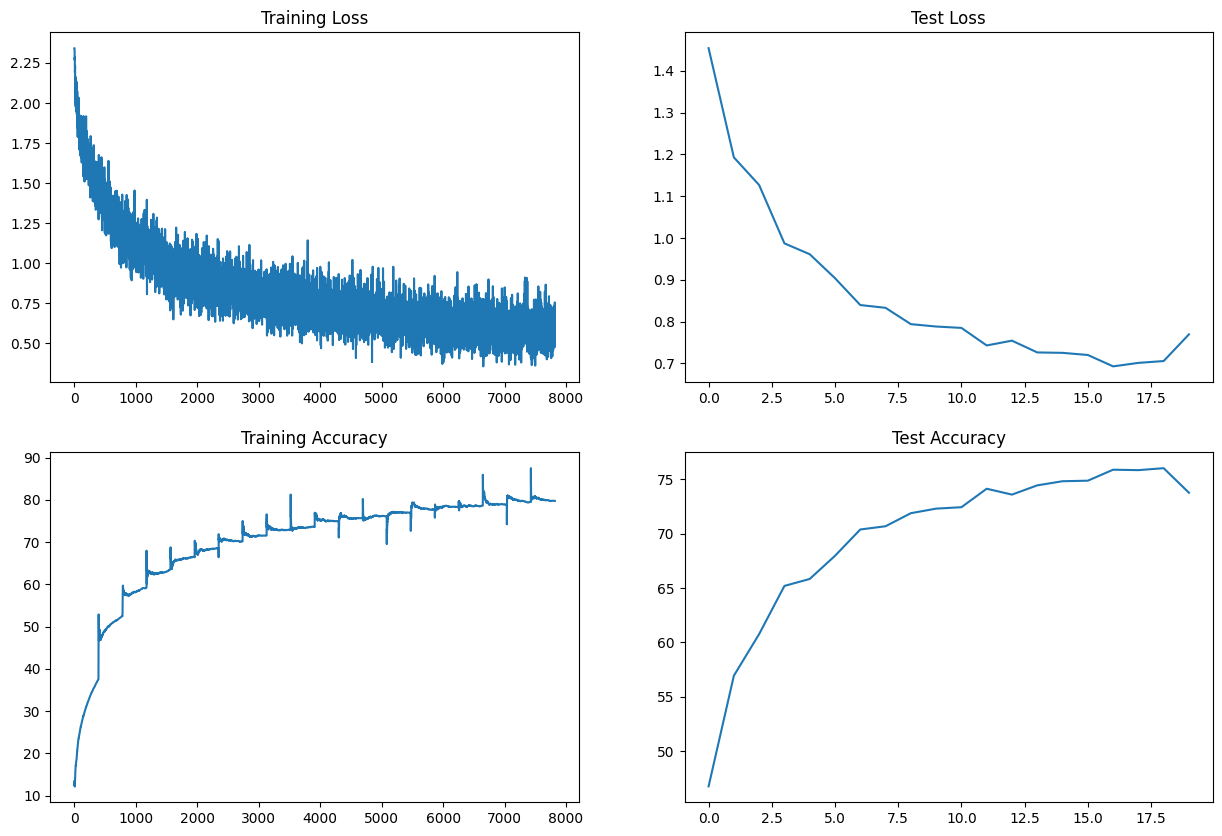

In [10]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")